# CS437 PA4 Part 1 - Text Generation with RNNs [20 marks]

Roll Number: 241000103

Name: Rafey Rana

Text generation is a challenging task in natural language processing (NLP) that involves generating new text that is coherent and contextually relevant. Recurrent neural networks (RNNs) have shown to be effective for this task as they can learn long-term dependencies in sequential data and generate new text based on the context of previously generated text.

In this assignment, we will explore the fundamentals of text generation with RNNs. We will begin by discussing the basics of NLP and RNNs, including their architecture and training procedures. By the end of this part, you will have created a model that will learn to (hopefully) produce jokes.

In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

## Exploring Embeddings [5 Marks]

One of the coolest things to play around with in NLP is Embeddings. You can find loads of articles online regarding where they are used, how they are trained, and why they are very useful. Put simply, they are fixed-size vector representations of tokens in natural language. This means you can represent words as vectors, sentences as vectors, even other entities like graphs as vectors!

So what really makes them different from something like One-Hot vectors? They're still vectors, no? Let's ignore the fact you probably thought of it like that.

What makes them special is that they have semantic meaning baked into them! This means you can model relationships between entities in text, which itself leads to a lot of fun applications. All modern architectures make use of Embeddings in some way.

This part will allow you to explore what Embeddings are. We will load in pretrained Embeddings here and examine some of their properties. If you're interested, feel free look up the Word2Vec model: this is the model that was trained to give us the embeddings you will see below.

In [2]:
# Download the pretrained word2vec model
corpus = api.load('text8')
model = Word2Vec(corpus)

print("Done loading word2vec model!")

Done loading word2vec model!


Now that we've loaded in the Embeddings, we can create an Embedding **layer** in PyTorch that will perform the processing step for us.

Note in the following cell how there is a given **vocab size** and **embedding dimension** for the model: this is important to note because some sets of Embeddings may be defined for a large set of words (a large vocab), whereas older ones perhaps have a smaller set (a small vocab); the Embedding dimension essentially tells us how many *features* have been learned for a given word, that will allow us to perform further processing on top of.

In [3]:
# Define embedding layer using gensim
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(model.wv.vectors))

# Get some information from the model
print(f"Vocab size: {len(model.wv.key_to_index)}")

print(f"Some of the words in the vocabulary:\n{list(model.wv.key_to_index.keys())[:30]}")

print(f"Embedding dimension: {model.wv.vectors.shape[1]}")

Vocab size: 71290
Some of the words in the vocabulary:
['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was', 'by', 'that', 'four', 'six', 'seven', 'with', 'on', 'are', 'it', 'from', 'or', 'his']
Embedding dimension: 100


Now, for a demonstration, we instantiate two words, turn them into numbers (encoding them via their index in the vocab), and pass them through the Embedding layer. 

Note how the resultant Embeddings both have the same shape: 1 word, and 100 elements in the vector.

In [4]:
# Take two words and get their embeddings
word1 = "king"
word2 = "queen"

def word2vec(word):
    return embedding_layer(torch.LongTensor([model.wv.key_to_index[word]]))

king_embedding = word2vec(word1)
queen_embedding = word2vec(word2)

print(f"Embedding Shape for '{word1}': {king_embedding.shape}")
print(f'the  embedding for king is {king_embedding}')
print(f"Embedding Shape for '{word2}': {queen_embedding.shape}")

Embedding Shape for 'king': torch.Size([1, 100])
the  embedding for king is tensor([[ 4.1887e-01, -5.1684e-01,  1.0522e+00,  2.1684e+00,  1.1878e+00,
         -5.6450e-02, -9.6188e-01,  2.3777e+00,  3.7719e-01,  3.1078e+00,
         -1.8418e+00, -1.9885e+00,  9.3107e-01,  1.7744e+00, -9.8257e-01,
         -9.0121e-01,  1.3060e+00,  1.7386e+00,  1.9442e+00, -7.1650e-01,
         -1.6610e+00,  1.1495e+00, -1.7654e+00,  6.8604e-01, -8.4197e-01,
          2.4738e+00,  4.3938e-01,  1.7568e+00,  1.9913e+00, -5.7157e-01,
          2.9734e-01, -8.0338e-01,  1.3138e+00, -1.0174e+00,  3.0585e+00,
         -1.1425e+00,  2.7208e+00, -2.1872e+00, -3.6851e+00, -2.2147e+00,
         -6.1082e-02, -1.4503e+00,  1.6549e+00, -2.1469e+00, -1.1978e+00,
         -2.3083e+00,  4.9880e-01, -9.8207e-01,  2.9846e+00, -2.9064e+00,
          1.6216e+00, -5.9237e-01, -2.2943e+00,  7.3239e-01,  1.1781e+00,
         -1.9849e+00, -2.2235e-03,  1.1178e+00,  1.2379e+00, -3.5217e-01,
          2.0638e+00, -1.3109e-01,  

When we have vectors whose scale is arbitrary, one nice way to measure how *similar* they are is with the Cosine Similarity measure.
<center>
    <img src="./assets/cosine-sim.png">
</center>

We can apply this idea to our Embeddings. To see how "similar" two words are to the model, we can generate their Embeddings and take the Cosine Similarity of them. This will be a number between -1 and 1 (just like the range of the cosine function). When the number is close to 0, the words are not similar.

In [5]:
def cosine_similarity(vec1, vec2):
    '''
    Computes the cosine similarity between two vectors
    '''

    vec1 = vec1.squeeze().reshape(1, -1)
    vec2 = vec2.squeeze().reshape(1, -1)
    print(vec1.shape)
    print(vec2.shape)

    # TODO: Compute the cosine similarity between the two vectors (using PyTorch)
    similarity_index =  F.cosine_similarity(vec1,vec2)
    return similarity_index

def compute_word_similarity(word1, word2):
    '''
    Takes in two words, computes their embeddings and returns the cosine similarity
    '''

    # TODO: Find the embeddings for the two words
    word1_embedding = word2vec(word1)
    word2_embedding = word2vec(word2)

    # TODO: Compute the cosine similarity between the two embeddings
    similarity = cosine_similarity(word1_embedding, word2_embedding)
    return similarity

# TODO: Define three words (one pair should be similar and one pair should be dissimilar) and compute their similarity
word1 = "from"
word2 = "nine"
word3 = "me"
print(f"Similarity between '{word1}' and '{word2}': {compute_word_similarity(word1, word2)}")
print(f"Similarity between '{word1}' and '{word3}': {compute_word_similarity(word1, word3)}")

torch.Size([1, 100])
torch.Size([1, 100])
Similarity between 'from' and 'nine': tensor([0.0934])
torch.Size([1, 100])
torch.Size([1, 100])
Similarity between 'from' and 'me': tensor([-0.0530])


## Generating Text with RNNs [15 Marks]

Now that we've gotten a glimpse of what Embeddings are, we can move on to making our first text model.

RNNs are capable of Seq2Seq modeling (mapping sequences to sequences). One form of this is generating text given an initial prompt. The model does this by:
1. Numericalizing the input text (and converting them to Embeddings)
2. Processing one set of tokens at a time
3. Generating a probability distribution of what word is *most likely* to come next, given the previous words
4. Predicting the word that maximizes this probability

Since we'd like to be able to generate long texts, we will use an LSTM which is better at modeling longer sequences, as you likely have heard before.

In [6]:
# Create an RNN model to generate text
class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # TODO: Create an Embedding layer given the vocab size and embedding dimension
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim= self.embedding_dim
        )

        # TODO: Create an LSTM layer given the embedding dimension, hidden dimension and number of layers
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers
        )

        # TODO: Create a fully connected layer given the hidden dimension and output dimension
        self.fc = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.output_dim
        )

    def forward(self, x, prev_state):
        '''
        Forward pass of the model
        '''
        # if x is the last word in this we will use it as our starting point
        # TODO: Get the embedding of the current input word (last output word)
        embed = self.embedding(x)


        # TODO: Get the output and the new hidden state by passing the lstm over embed and the previous state
        output, state = self.lstm(embed, prev_state)

        # TODO: Get the logits for the next word by passing the output of the LSTM through the fully connected layer
        logits = self.fc(output)

        return logits, state
    
    def init_hidden(self, batch_size):
        '''
        Initializes hidden state of the LSTM. We'll use this to pass an initial hidden state of zeros to the LSTM.
        '''

        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

Creating the model was the simple part. The tricky part is processing our data for this task. 

<center>
    <img src="./assets/LM1.jpg">
</center>

We want to set up the task as follows. The model will take in a numericalized representation of a sequence of words. It's goal will be to generate the next word that should follow that sequence.

One problem we will face is that creating tensors can be a bit problematic since the sentences are variable length. We will take a naive approach and simply flatten the whole dataset so it seems that we just have one *very long* string. This will make it much easier to generate pairs of sentences that are of the same length (that follow one another), and let us pack them into fixed-size tensors.

In [7]:
# Create a dataset for the jokes dataset
class JokesDataset(Dataset):
    def __init__(self, path_to_jokes, sequence_length):
        self.jokes_df = pd.read_csv(path_to_jokes)
        self.jokes = self.jokes_df['Joke'].tolist()
        self.words = self.jokes_df['Joke'].str.cat(sep=' ').split()
        self.vocab = set([w for w in self.words])
        self.sequence_length = sequence_length

        self.word_to_index = {word: index for index, word in enumerate(self.vocab)}
        self.index_to_word = {index: word for index, word in enumerate(self.vocab)}

        self.word_indexes = [self.word_to_index[word] for word in self.words]

    def __len__(self):
        return len(self.jokes)
    
    def __getitem__(self, index):
        '''
        Return the item at the given index, making sure the sequence length is not exceeded
        '''

        return (
            torch.tensor(self.word_indexes[index:index+self.sequence_length]),
            torch.tensor(self.word_indexes[index+1:index+self.sequence_length+1]),
        )



jokes_dataset = JokesDataset('./datasets/jokes.csv', sequence_length=10)
jokes_dataloader = DataLoader(jokes_dataset, batch_size=32, shuffle=True)

If you're confused, take some time to print out a few examples from the Dataset object, check out the shapes and how they map to the words that we defined in the dictionaries.

With that done, we can move on to training our model! The process is consistent with what we've done before. The only tricky part is formatting our model's predictions to resemble the ground truth (because of the LSTM), and dealing with the updated **Hidden** and **Cell** states. Otherwise, everything is the same since we've created an interface for our Dataset.

Note here, we use the Cross Entropy Loss since we want the model to be able to classify what word is to come next. This is similar to basic Classification tasks since it is simply predicting a probability distribution of a number of classes (the vocab in this case).

In [17]:
def train(
        model,
        dataloader,
        loss_fn,
        optimizer,
        epochs,
        device,
        sequence_length=10 # this was previously 10
):
    losses = []
    model.train()

    for epoch in range(epochs):

        # TODO: Initialize the hidden state
        state_h, state_c = model.init_hidden(sequence_length)

        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            # TODO: Get the output from the model
            # Hint: Look at the forward function of the model and notice that it returns two values
            # Hint: The prev_state is a tuple of the Hidden state and the Cell state
            y_pred, (state_h, state_c) = model(X, (state_h, state_c))
            y_pred = y_pred.transpose(1,2) # just some reshaping to make the loss function work

            # TODO: Compute the loss
            loss = loss_fn(y_pred, y)

            # Detach the hidden state from the graph to prevent backpropagation through the entire history
            state_h = state_h.detach()
            state_c = state_c.detach()

            # TODO: Zero the gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
        losses.append(loss.item())

    return losses


# Create the model
model = LSTMGenerator(
    vocab_size=len(jokes_dataset.vocab),
    embedding_dim=100,
    hidden_dim=100,
    output_dim=len(jokes_dataset.vocab),
    num_layers=1
)

# Train the model
train_losses = train(
    model=model,
    dataloader=jokes_dataloader,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.parameters(), lr=0.001),
    epochs= 50, 
    device="cuda" if torch.cuda.is_available() else "cpu",
    sequence_length=10
)


Epoch: 1, Loss: 5.997169017791748
Epoch: 2, Loss: 5.8835930824279785
Epoch: 3, Loss: 5.314061164855957
Epoch: 4, Loss: 4.999398708343506
Epoch: 5, Loss: 5.015504360198975
Epoch: 6, Loss: 4.524610996246338
Epoch: 7, Loss: 3.9807558059692383
Epoch: 8, Loss: 3.5178558826446533
Epoch: 9, Loss: 3.3368542194366455
Epoch: 10, Loss: 2.889758825302124
Epoch: 11, Loss: 2.543971300125122
Epoch: 12, Loss: 2.4106736183166504
Epoch: 13, Loss: 2.0313477516174316
Epoch: 14, Loss: 1.8278049230575562
Epoch: 15, Loss: 1.6860852241516113
Epoch: 16, Loss: 1.4477689266204834
Epoch: 17, Loss: 1.3796559572219849
Epoch: 18, Loss: 1.3695909976959229
Epoch: 19, Loss: 1.4789835214614868
Epoch: 20, Loss: 1.3896570205688477
Epoch: 21, Loss: 1.2171138525009155
Epoch: 22, Loss: 1.310896873474121
Epoch: 23, Loss: 1.346426010131836
Epoch: 24, Loss: 1.1874579191207886
Epoch: 25, Loss: 1.1864475011825562
Epoch: 26, Loss: 1.1318899393081665
Epoch: 27, Loss: 1.2003707885742188
Epoch: 28, Loss: 1.295810580253601
Epoch: 29, 

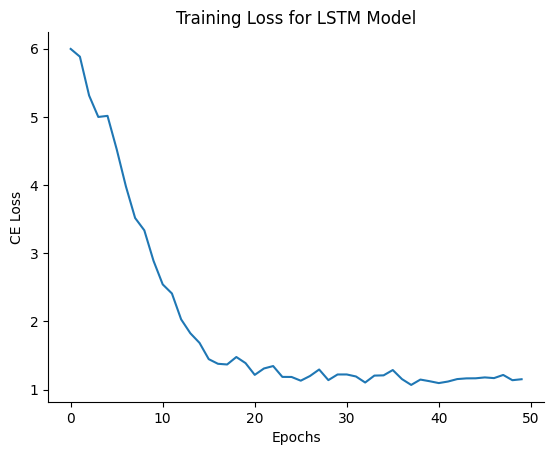

In [18]:
# Plot the losses
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
plt.title("Training Loss for LSTM Model")
sns.despine()
plt.show()

Now that we're done with training the model, let's see how it performs when we give the prompt.

Note that this can be slightly complicated since we don't have a conveniently formatted dataset, so we have to take care that the shapes of the Hidden and Cell states are correspond to the length we're working on.

If your model doesn't generate jokes that make you laugh, there's a few things you can try:
1. Open up your gradebook
2. Tweak the sequence length your model sees
3. Try out better Pretrained Embeddings (maybe ones that are more recent or have a higher dimensionality)
4. Train for more epochs
5. Use an LSTM with more layers

Note that for the purposes for this assignment, don't worry about your model not generating something perfect, as long as it generates *something*.

In [19]:
# Generate text using the model
def generate_text(model, dataset, seed_text, num_words=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    words = seed_text.split()
    model.eval()

    # TODO: Initialize the state of the LSTM corresponding to the length of the seed text
    state_h, state_c = model.init_hidden(len(words))
    
    # Convert the seed text to a tensor
    seed_text = torch.tensor([dataset.word_to_index[word] for word in seed_text.split()]).to(device)

    # Initialize the output with the seed text
    output = seed_text

    with torch.no_grad():
        for i in range(num_words):
            
            x = [[dataset.word_to_index[word] for word in words[i:]]]
            x = torch.tensor(x).to(device)

            # TODO: Get the model output and updates states (same as before)
            y_pred, (state_h, state_c) = model(x, (state_h, state_c))

            # Detach the hidden state from the graph to prevent backpropagation through the entire history
            state_c = state_c.detach()
            state_h = state_h.detach()

            # Get the last predicted word
            last_word_logits = y_pred[0][-1]
            last_word_idx = torch.argmax(last_word_logits).unsqueeze(0)
            words.append(dataset.index_to_word[last_word_idx.item()])            

            # Append the last predicted word to the output
            output = torch.cat((output, last_word_idx), dim=0)

    return ' '.join(words)

generate_text(model, jokes_dataset, "What did the science student say to the chicken?", num_words=150)

'What did the science student say to the chicken? Q: Why did the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to the other seasons? Because they way to'